# Sensitivity, Gauss-Newton and DOI
This notebook illustrates synthetically the 1D sensitivity of the different FDEM forward model and their implications.

In [10]:
import sys
sys.path.append('../src')
from emagpy import Problem
import numpy as np
import matplotlib.pyplot as plt

## Sensitivity
By perturbing each layer of the model slightly an computing the effect it has on the apparent electrical conductivity observed, one can reconstruct the sensitivity profile of each 1D model. This is done automatically in the `computeSens()` method.

2/30 data removed (filterRange).


Text(0, 0.5, 'Depth [m]')

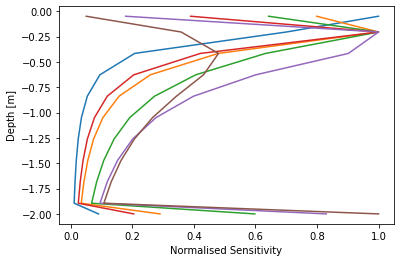

In [4]:
k = Problem()
k.createSurvey('../src/examples/cover-crop/coverCropTransect.csv')
k.filterRange(vmax=50)
k.setInit(depths0=np.linspace(0.1, 2, 10))
k.depths = k.depths0.copy() # need to specify initial model to compute sensitivity
k.models = k.conds0.copy()
sens = k.computeSens()

depth = k.depths[0][0,:]
mdepths = np.r_[depth[0]/2, depth[:-1] + np.diff(depth)/2, depth[-1]]
fig, ax = plt.subplots()
ax.plot(sens[0][:,:,0], -mdepths)
ax.set_xlabel('Normalised Sensitivity')
ax.set_ylabel('Depth [m]')

Note that the sensitivity of the last layer is large as this layer extend to $-\infty$ hence containing the remaining sensitivity.

## Gauss-Newton approach
The sensitivity recovered from the 'perturbed method' can help to compute the Jacobian matrix needed to use the Gauss-Newton method. This method is now available in the `invert` method.

Survey 1/1
28/28 inverted


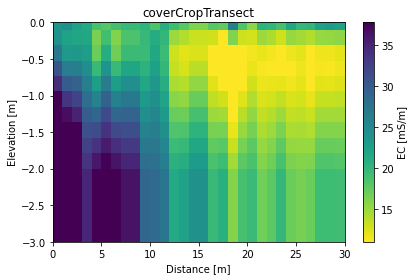

In [5]:
k.invert(forwardModel='CS', method='Gauss-Newton', alpha=0.07, regularization='l2')
k.showResults()

28/28 invertedSurvey 1/1
28/28 inverted


Text(0.5, 1.0, '(b) Gauss-Newton approach')

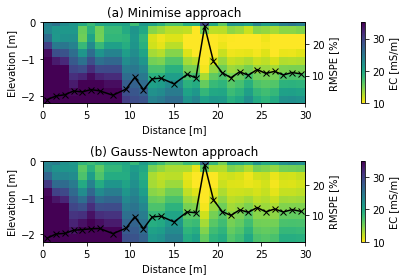

In [6]:
fig, axs = plt.subplots(2, 1)
ax = axs[0]
k.invert(forwardModel='CS', method='L-BFGS-B', alpha=0.07, regularization='l2')
k.showResults(index=0, ax=ax, vmin=10, vmax=35, maxDepth=2.2, rmse=True)
ax.set_title('(a) Minimise approach')

ax = axs[1]
k.invert(forwardModel='CS', method='Gauss-Newton', alpha=0.07, regularization='l2')
k.showResults(index=0, ax=ax, vmin=10, vmax=35, maxDepth=2.2, rmse=True)
ax.set_title('(b) Gauss-Newton approach')

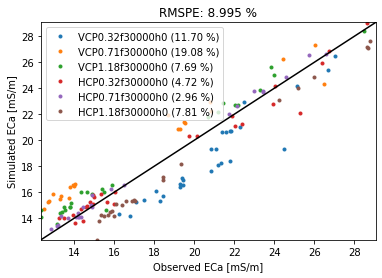

In [7]:
k.showOne2one()

# Depth of investigation
A depth of investigation (DOI) can be computed assuming that 70% of the signal comes above this depth. This is done using the cumulated sensitivity profiles computed from `computeSens()`. The deepest DOI of all configurations is chosen. DOI are computed using `computeDOI()` and can be plotted on top of the inverted model using `showResults(doi=True)`.
> Note that if the DOI is deeper than the last depth of the inverted model, the DOI will be set to the greatest depth. That should mean that you can probably make your model deeper as the coils configuration collected allow it.

2/30 data removed (filterRange).
Survey 1/1
28/28 inverted
Computing DOI 1/1 done


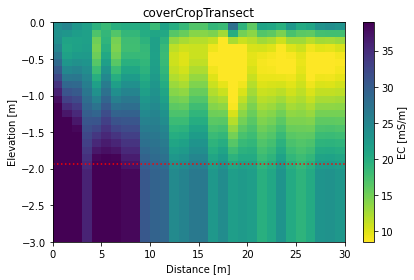

In [8]:
# for CS on no high EC ground, the DOI will be constant
k = Problem()
k.createSurvey('../src/examples/cover-crop/coverCropTransect.csv')
k.filterRange(vmax=50)
k.setInit(depths0=np.linspace(0.1, 2, 20))
k.invert(method='Gauss-Newton')
k.computeDOI()
k.showResults(doi=True)

2/30 data removed (filterRange).
Computing DOI 1/1 done


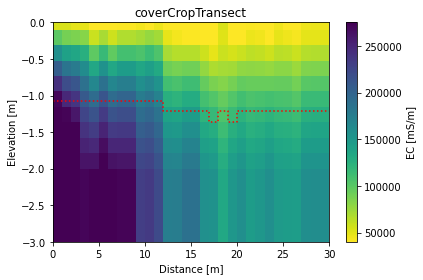

In [9]:
# for FS on high EC ground it might change
k = Problem()
k.createSurvey('../src/examples/cover-crop/coverCropTransect.csv')
k.filterRange(vmax=50)
s0 = k.surveys[0]
s0.df.loc[:, s0.coils] = s0.df[s0.coils].values*2000 # increase ECa artificially
k.setInit(depths0=np.linspace(0.1, 2, 10))
k.invert(forwardModel='FSlin', method='Gauss-Newton')
k.computeDOI(nlayers=15) # this takes a while
k.showResults(doi=True)

### Observations
- no change in DOI with CS as CS is mathematically defined and does not depend on the EC values of the inverted profile
- decrease in DOI with FS on very conductive (EC > 1000) model.
Note that if the top layer had a large EC (> 1000) compared the bottom layers, this will create a 'shielding' effect and decrease the sensitivity to underneath layers.